In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#from imageio import imread
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Cropping2D, Dropout, ZeroPadding2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from scipy.misc import imread
from utils import get_resized_train_data
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
from skimage.transform import resize
from PIL import Image
import utils
from skimage.morphology import label
from constants import *
from skimage.color import rgb2gray

//anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])


# print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

# def analyze_image(patient):
#     img = load_input_image(patient, inp_folder=TEST_FOLDER)
#     img = utils.resize_train_images(img)
#     img = np.expand_dims(img, axis=0)
#     segmented_img = model.predict(img)
#     segmented_img = np.squeeze(segmented_img)
#     rle = prob_to_rles(segmented_img)
#     s = pd.Series({'ImageId': patient, 'EncodedPixels': rle})
#     im_df = pd.DataFrame()
#     im_df = im_df.append(s, ignore_index=True)
#     return im_df

In [3]:
model = load_model('logs/unet-model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
test_patients = os.listdir(TEST_FOLDER)
# test_patients = next(os.walk(TEST_FOLDER))[1]

In [5]:
X_test = np.zeros((len(test_patients), IMG_HEIGHT, IMG_WIDTH,
                   IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
for n, id_ in tqdm(enumerate(test_patients), total=len(test_patients)):
    path = TEST_FOLDER + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS),
                            mode='constant', preserve_range=True)
    X_test[n] = img
print(sizes_test)

  0%|          | 0/65 [00:00<?, ?it/s]//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  3%|▎         | 2/65 [00:00<00:03, 15.94it/s]

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 44.63it/s]

[[256, 256], [512, 680], [512, 640], [520, 696], [512, 680], [519, 161], [519, 161], [256, 256], [512, 640], [256, 256], [512, 640], [512, 680], [256, 256], [256, 256], [519, 253], [512, 640], [519, 253], [512, 640], [256, 256], [520, 696], [256, 256], [256, 256], [520, 696], [256, 256], [524, 348], [512, 680], [256, 256], [260, 347], [520, 348], [256, 256], [256, 256], [512, 640], [256, 256], [524, 348], [512, 680], [512, 680], [519, 162], [519, 162], [512, 680], [524, 348], [520, 348], [519, 253], [260, 347], [524, 348], [520, 348], [256, 256], [520, 696], [260, 347], [256, 256], [256, 256], [512, 640], [256, 256], [256, 256], [256, 256], [256, 256], [256, 256], [519, 253], [390, 239], [512, 680], [512, 640], [520, 348], [256, 256], [256, 256], [256, 256], [260, 347]]


In [7]:
print("Making predictions for %d test patients" % len(test_patients))
preds_test = model.predict(X_test, verbose=1)
print(preds_test.shape)

Making predictions for 65 test patients
65/65 [==============================] - 357s 5s/step
(65, 256, 256, 1)


### Visualization
Let's visualize some of our test images and predictions for them

In [14]:
preds_test[ix]

array([[[8.82478588e-08],
        [2.88319377e-08],
        [2.68121721e-06],
        ...,
        [2.71864166e-03],
        [9.77970310e-04],
        [1.51044531e-02]],

       [[1.38357326e-10],
        [3.52428331e-09],
        [3.97072154e-06],
        ...,
        [2.40417360e-03],
        [2.22884220e-04],
        [1.21515582e-03]],

       [[3.28136442e-11],
        [1.99865497e-07],
        [1.15873925e-04],
        ...,
        [1.86398020e-03],
        [1.00318721e-06],
        [7.17761077e-06]],

       ...,

       [[9.22231805e-11],
        [2.31093281e-07],
        [2.90446067e-08],
        ...,
        [7.76749238e-12],
        [6.35496294e-14],
        [5.18674756e-11]],

       [[3.41049328e-10],
        [2.27044117e-09],
        [1.30112601e-10],
        ...,
        [8.29871213e-15],
        [4.23999028e-15],
        [8.51819518e-11]],

       [[1.28260709e-07],
        [1.79874415e-09],
        [4.43430327e-11],
        ...,
        [2.60432106e-12],
        [5.7414

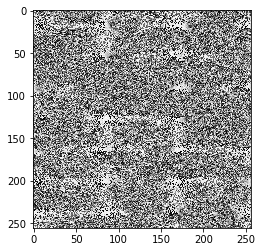

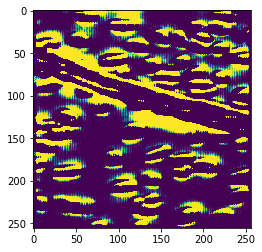

In [43]:
ix = random.randint(0, len(preds_test))
plt.imshow(X_test[ix])
plt.show()
plt.imshow(np.squeeze(preds_test[ix]))
plt.show()

In [17]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

new_test_ids = []
rles = []
for n, id_ in enumerate(test_patients):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    if len(rle) == 0:
        from pdb import set_trace
        set_trace()
        print("help")
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(
    lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission_unet.csv', index=False)


KeyboardInterrupt: 